In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv("./train.csv")

# Funciones para usar mean encoding

In [3]:
def mean_target_encoding(train, nombrefeat, nombretarget):
        
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean) #Saco promedio
    temp = preprocessing.scale(temp) #Normalizo
    train[nombrefeat + "_mean"] = temp #Dejo en el DF
    
    return train

In [4]:
def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

## Busco posibles features para agregar al modelo

In [49]:
df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['id','idzona','lat','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
train.dropna()
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

#X_train = mean_target_encoding(X_train, "tipodepropiedad", "precio")
X_train = mean_target_encoding(X_train, "provincia", "precio")
X_train = mean_target_encoding(X_train, "ciudad", "precio")
X_train = mean_target_encoding(X_train, "direccion", "precio")

X_test = mean_target_decoding(X_test, "provincia", X_train)
#X_test = mean_target_decoding(X_test, "tipodepropiedad", X_train)
X_test = mean_target_decoding(X_test, "ciudad", X_train)
X_test = mean_target_decoding(X_train, "direccion", X_train)
                               
                               
X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 
X_train.fillna(0, inplace=True)
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 
X_test.fillna(0, inplace=True)
X_train

/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,fecha,agregados,provincia_mean,ciudad_mean,direccion_mean
54142,0.0,2.0,1.0,1.0,65.0,65.0,2015,0.0,1.372702,0.718434,-0.313963
62241,20.0,3.0,2.0,3.0,296.0,180.0,2015,0.0,0.348323,-1.242376,-0.330521
69388,0.0,3.0,2.0,3.0,212.0,0.0,2013,0.0,-0.715778,-0.419289,0.000000
23347,0.0,4.0,2.0,4.0,360.0,201.0,2016,3.0,-0.855365,-0.006124,0.000000
137421,10.0,3.0,0.0,2.0,395.0,0.0,2015,1.0,1.372702,0.939263,1.411297
...,...,...,...,...,...,...,...,...,...,...,...
119879,5.0,3.0,2.0,3.0,182.0,225.0,2013,3.0,-0.193262,-0.008352,0.000000
103694,0.0,2.0,1.0,1.0,59.0,59.0,2015,1.0,0.348323,-1.532480,0.000000
131932,1.0,3.0,2.0,2.0,105.0,105.0,2013,3.0,-0.255006,-0.609471,0.000000
146867,10.0,4.0,1.0,2.0,80.0,80.0,2016,2.0,0.348323,-1.532480,0.000000


# score

In [50]:
# Crear el modelo 
forest = RandomForestRegressor(n_estimators= 788, min_samples_split=4,min_samples_leaf=1,max_features= "sqrt",max_depth=38,bootstrap = True, verbose=2)
#Lo entreno 
forest.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 788
building tree 2 of 788
building tree 3 of 788
building tree 4 of 788
building tree 5 of 788
building tree 6 of 788
building tree 7 of 788
building tree 8 of 788
building tree 9 of 788
building tree 10 of 788
building tree 11 of 788
building tree 12 of 788
building tree 13 of 788
building tree 14 of 788
building tree 15 of 788
building tree 16 of 788
building tree 17 of 788
building tree 18 of 788
building tree 19 of 788
building tree 20 of 788
building tree 21 of 788
building tree 22 of 788
building tree 23 of 788
building tree 24 of 788
building tree 25 of 788
building tree 26 of 788
building tree 27 of 788
building tree 28 of 788
building tree 29 of 788
building tree 30 of 788
building tree 31 of 788
building tree 32 of 788
building tree 33 of 788
building tree 34 of 788
building tree 35 of 788
building tree 36 of 788
building tree 37 of 788
building tree 38 of 788
building tree 39 of 788
building tree 40 of 788
building tree 41 of 788
building tree 42 of 788
b

building tree 337 of 788
building tree 338 of 788
building tree 339 of 788
building tree 340 of 788
building tree 341 of 788
building tree 342 of 788
building tree 343 of 788
building tree 344 of 788
building tree 345 of 788
building tree 346 of 788
building tree 347 of 788
building tree 348 of 788
building tree 349 of 788
building tree 350 of 788
building tree 351 of 788
building tree 352 of 788
building tree 353 of 788
building tree 354 of 788
building tree 355 of 788
building tree 356 of 788
building tree 357 of 788
building tree 358 of 788
building tree 359 of 788
building tree 360 of 788
building tree 361 of 788
building tree 362 of 788
building tree 363 of 788
building tree 364 of 788
building tree 365 of 788
building tree 366 of 788
building tree 367 of 788
building tree 368 of 788
building tree 369 of 788
building tree 370 of 788
building tree 371 of 788
building tree 372 of 788
building tree 373 of 788
building tree 374 of 788
building tree 375 of 788
building tree 376 of 788


building tree 665 of 788
building tree 666 of 788
building tree 667 of 788
building tree 668 of 788
building tree 669 of 788
building tree 670 of 788
building tree 671 of 788
building tree 672 of 788
building tree 673 of 788
building tree 674 of 788
building tree 675 of 788
building tree 676 of 788
building tree 677 of 788
building tree 678 of 788
building tree 679 of 788
building tree 680 of 788
building tree 681 of 788
building tree 682 of 788
building tree 683 of 788
building tree 684 of 788
building tree 685 of 788
building tree 686 of 788
building tree 687 of 788
building tree 688 of 788
building tree 689 of 788
building tree 690 of 788
building tree 691 of 788
building tree 692 of 788
building tree 693 of 788
building tree 694 of 788
building tree 695 of 788
building tree 696 of 788
building tree 697 of 788
building tree 698 of 788
building tree 699 of 788
building tree 700 of 788
building tree 701 of 788
building tree 702 of 788
building tree 703 of 788
building tree 704 of 788


[Parallel(n_jobs=1)]: Done 788 out of 788 | elapsed:   49.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=38,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=788,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=2, warm_start=False)

Text(0, 0.5, 'Score')

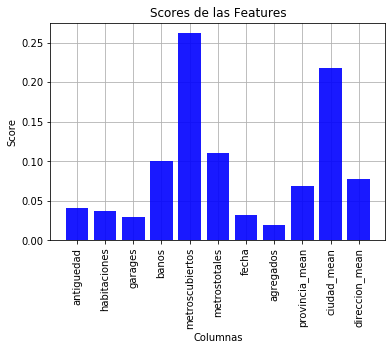

In [51]:
columnas = X_train.columns
k_utilizado = np.arange(15)
scores = forest.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [52]:
scores = forest.feature_importances_
scores

array([0.04088844, 0.03772453, 0.02991485, 0.10078965, 0.26184507,
       0.11115004, 0.03263936, 0.01995002, 0.06913498, 0.21831912,
       0.07764393])